# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Описание данных

***id*** — уникальный идентификатор скважины;

***f0***, ***f1***, ***f2*** — три признака точек (неважно, что они означают, но сами признаки значимы);

**product** — объём запасов в скважине (тыс. баррелей).

## Условия задачи

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

Загружаем необходимые библиотеки для проекта:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.metrics import r2_score, mean_squared_error

<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты  на месте
</div>


Загружаем три датафрейма для трёх регионов:

In [2]:
try:
    geo_data_0 = pd.read_csv('geo_data_0.csv')
    geo_data_1 = pd.read_csv('geo_data_1.csv')
    geo_data_2 = pd.read_csv('geo_data_2.csv')
except:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Посмотрим первичную информацию о данных со всех регионов:

In [3]:
print(geo_data_0.info())
print(geo_data_1.info())
print(geo_data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column  

Видим, что в каждом датафрейме по 100 тыс. строк (скважин). Также в данных отсутствуют пропуски. Далее перейдём к более детальному расмотрению данных по регионам в отдельности.

### Данные геологоразведки первого региона

In [4]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


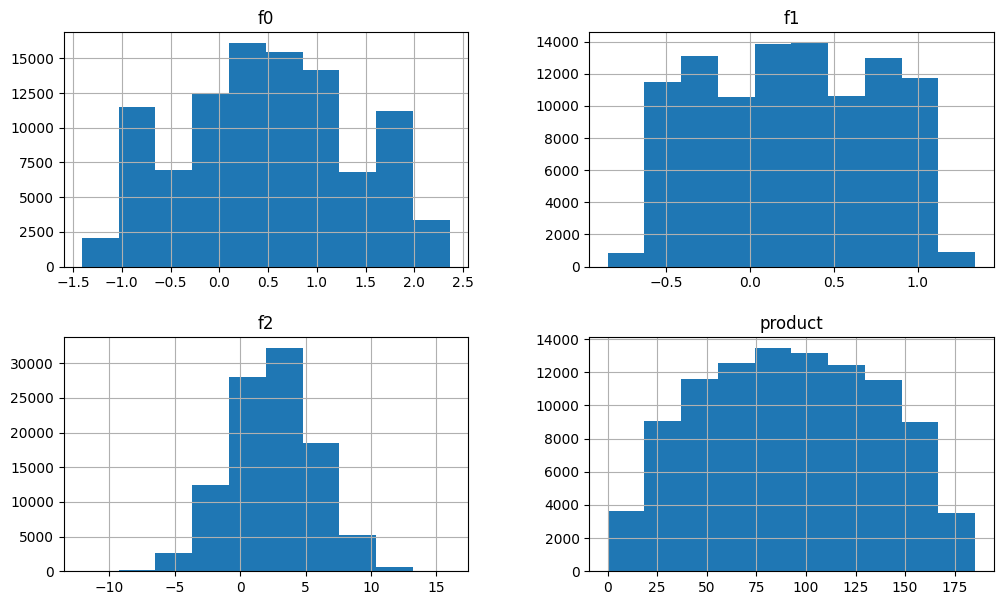

In [6]:
geo_data_0.hist(figsize=(12, 7))
plt.show()

<ipython-input-7-63bb41b533b9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(geo_data_0.corr(), annot=True)


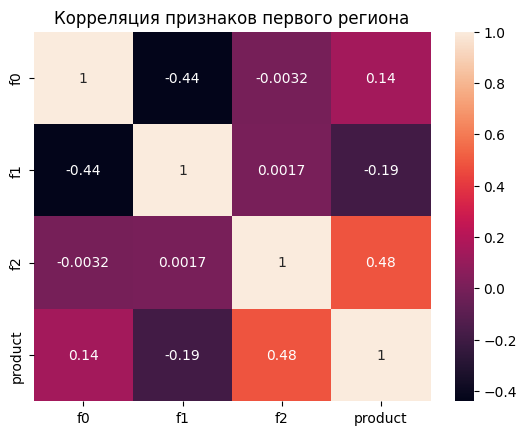

In [7]:
sns.heatmap(geo_data_0.corr(), annot=True)

plt.title("Корреляция признаков первого региона")

plt.show()

### Данные геологоразведки второго региона

In [8]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [9]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


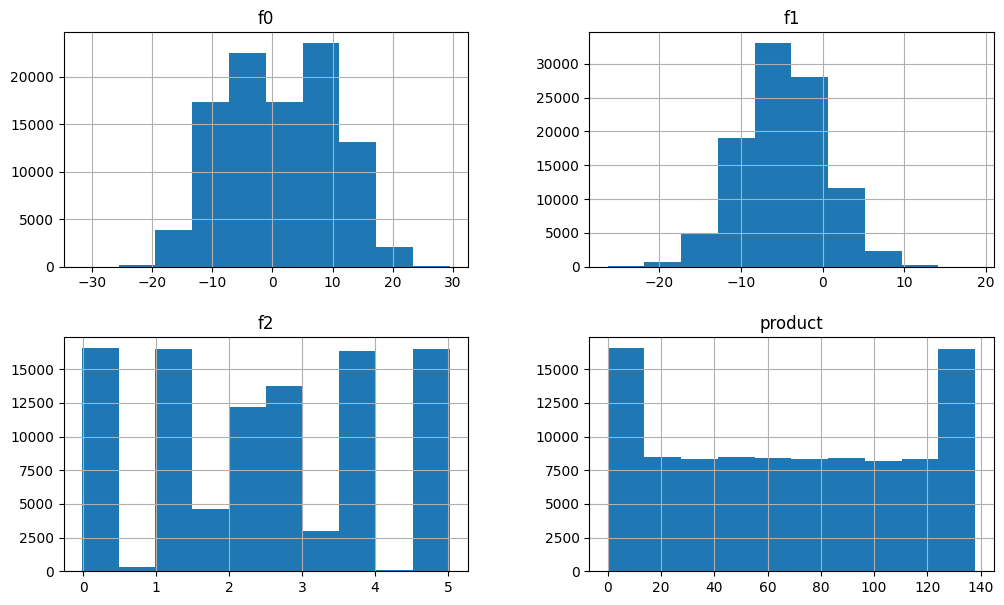

In [10]:
geo_data_1.hist(figsize=(12, 7))
plt.show()

<ipython-input-11-00a7fe7b91c8>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(geo_data_1.corr(), annot=True)


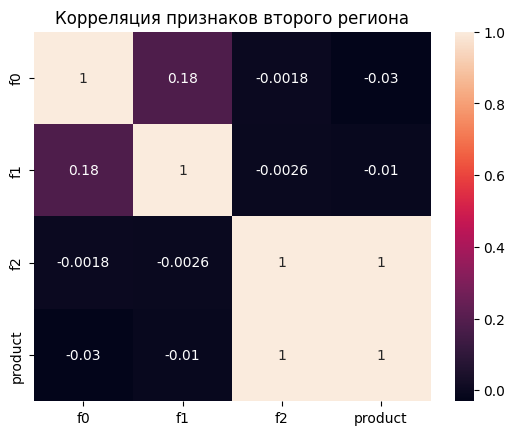

In [11]:
sns.heatmap(geo_data_1.corr(), annot=True)

plt.title("Корреляция признаков второго региона")

plt.show()

### Данные геологоразведки третьего региона

In [12]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [13]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


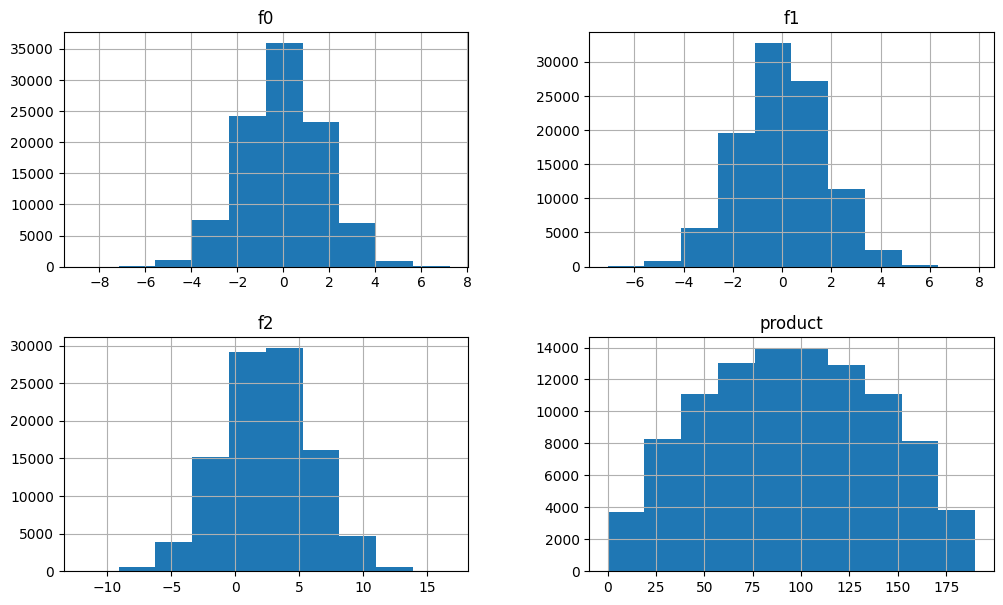

In [14]:
geo_data_2.hist(figsize=(12, 7))
plt.show()

<ipython-input-15-e992c1dc8cb9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(geo_data_2.corr(), annot=True)


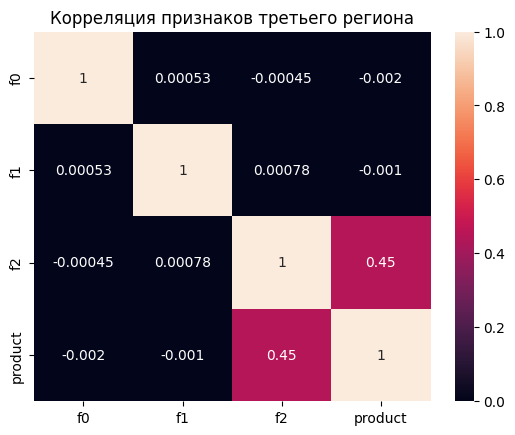

In [15]:
sns.heatmap(geo_data_2.corr(), annot=True)

plt.title("Корреляция признаков третьего региона")
plt.show()

### Выводы

Видим, что во всех трёх датафреймах присутствует небольшой разброс данных, поэтому далее прибегнем к масштабированию стандартизацией к признакам точек.

Также можем отметить, что по большей части данные геологоразведки первого и третьего регинов распределны нормально, без ярковыраженных выбросов. А вот в данных второго района мы можем наблюдать немного инную ситуацию особенно для столбцов ***f2*** и ***product***. Насколько ярко это отразится на предсказаниях нашей будущей модели, узнаем в следующих этапах проекта.

По тепловым картам и корреляции в данных можем отметить, что ярче всего во всех трёх случаях проявляется зависимость целевого признака от прищнака ***f2***, а во втором регионе и вовсе коэффициент корреляции равен 1. Такие показатели должны положительно сказаться на результатах предсказания модели, обученной по таким данным.

## Деление выборки и масштабирование признаков

Перед обучением и проверкой модели поделим наши данные на обучающую и валидационную выборку в соотношении 75/25. Для этого зададим целевой признак - столбец ***product***, а в описательные признаки передадим столбцы с тремя признаками точек (***f0***, ***f1***, ***f2***):

In [16]:
target_geo_0 = geo_data_0['product']
features_geo_0 = geo_data_0[['f0', 'f1', 'f2']]

target_geo_1 = geo_data_1['product']
features_geo_1 = geo_data_1[['f0', 'f1', 'f2']]

target_geo_2 = geo_data_2['product']
features_geo_2 = geo_data_2[['f0', 'f1', 'f2']]

Далее делим данные каждого датафрейма на обучающую и валидационную выборки и сразу же проверяем размерность, чтобы убедиться, что деление прошло корректно:

In [17]:
features_geo_0_train, features_geo_0_valid, target_geo_0_train, target_geo_0_valid = train_test_split(features_geo_0, target_geo_0,
                                                                              test_size=0.25, random_state=123)

features_geo_1_train, features_geo_1_valid, target_geo_1_train, target_geo_1_valid = train_test_split(features_geo_1, target_geo_1,
                                                                              test_size=0.25, random_state=123)

features_geo_2_train, features_geo_2_valid, target_geo_2_train, target_geo_2_valid = train_test_split(features_geo_2, target_geo_2,
                                                                              test_size=0.25, random_state=123)

In [18]:
print(target_geo_0_train.shape, target_geo_0_valid.shape)
print(target_geo_1_train.shape, target_geo_1_valid.shape)
print(target_geo_2_train.shape, target_geo_2_valid.shape)

(75000,) (25000,)
(75000,) (25000,)
(75000,) (25000,)


Далее приступим по очередности к масштабированию признаков с помощью стандартизации и после будем выводить описательную характеристику по признакам, чтобы убедиться, что масштабирование прошло успешно:

### Масштабирование первого региона

In [19]:
pd.set_option('display.float_format', '{:,.2f}'.format)

In [20]:
scaler = StandardScaler()
scaler.fit(features_geo_0_train)

features_geo_0_train = pd.DataFrame(scaler.transform(features_geo_0_train))
features_geo_0_valid = pd.DataFrame(scaler.transform(features_geo_0_valid))

In [21]:
features_geo_0_train.describe()

,0,1,2
count,"75,000.00","75,000.00","75,000.00"
mean,0.00,0.00,0.00
std,1.00,1.00,1.00
min,-2.19,-2.18,-3.90
25%,-0.66,-0.89,-0.68
50%,0.00,-0.00,0.00
75%,0.66,0.89,0.68
max,2.14,2.15,4.16


In [22]:
features_geo_0_valid.describe()

,0,1,2
count,"25,000.00","25,000.00","25,000.00"
mean,0.01,-0.01,0.00
std,1.00,1.00,1.01
min,-2.12,-2.10,-4.50
25%,-0.66,-0.92,-0.68
50%,0.01,-0.01,0.01
75%,0.67,0.89,0.69
max,2.08,2.17,3.65


### Масштабирование второго региона

In [23]:
scaler = StandardScaler()
scaler.fit(features_geo_1_train)

features_geo_1_train = pd.DataFrame(scaler.transform(features_geo_1_train))
features_geo_1_valid = pd.DataFrame(scaler.transform(features_geo_1_valid))

In [24]:
features_geo_1_train.describe()

,0,1,2
count,"75,000.00","75,000.00","75,000.00"
mean,0.00,0.00,-0.00
std,1.00,1.00,1.00
min,-3.65,-4.21,-1.47
25%,-0.83,-0.68,-0.87
50%,-0.00,-0.00,-0.28
75%,0.83,0.68,0.89
max,3.16,4.60,1.48


In [25]:
features_geo_1_valid.describe()

,0,1,2
count,"25,000.00","25,000.00","25,000.00"
mean,0.01,0.00,0.01
std,1.00,1.00,1.00
min,-3.23,-4.02,-1.47
25%,-0.81,-0.67,-0.87
50%,0.02,-0.00,0.29
75%,0.85,0.68,0.89
max,2.72,3.79,1.48


### Масштабирование третьего региона

In [26]:
scaler = StandardScaler()
scaler.fit(features_geo_2_train)

features_geo_2_train = pd.DataFrame(scaler.transform(features_geo_2_train))
features_geo_2_valid = pd.DataFrame(scaler.transform(features_geo_2_valid))

In [27]:
features_geo_2_train.describe()

,0,1,2
count,"75,000.00","75,000.00","75,000.00"
mean,-0.00,-0.00,0.00
std,1.00,1.00,1.00
min,-5.06,-4.09,-4.17
25%,-0.67,-0.68,-0.68
50%,0.00,-0.00,-0.00
75%,0.67,0.67,0.68
max,4.19,4.09,4.11


In [28]:
features_geo_2_valid.describe()

,0,1,2
count,"25,000.00","25,000.00","25,000.00"
mean,0.01,0.01,0.00
std,1.01,1.00,1.01
min,-3.73,-3.79,-4.01
25%,-0.67,-0.67,-0.68
50%,0.01,-0.00,-0.00
75%,0.68,0.68,0.69
max,4.07,4.54,3.97


Во всех трёх случаях масштабирование признаков выполнено.

## Обучение и проверка модели

Приступим к обучению модели и замеру метрик её качества. Для каждого из трёх регионов мы обучим модель линейной регрессии и спрогнозируем предсказания на валидационной выборке, предварительно записав и сохранив их в перемнных. Далее для всех результатов замерим две метрики качества для задачи регрессии - среднеквадратичную ошибку RMSE и коэффициент детерминации (метрику R2).

### Первый регион

In [29]:
model_geo_0 = LinearRegression()
model_geo_0.fit(features_geo_0_train, target_geo_0_train)
predict_geo_0 = model_geo_0.predict(features_geo_0_valid)

rmse_geo_0 = mean_squared_error(target_geo_0_valid, predict_geo_0)**0.5

print('Среднеквадратичная ошибка RMSE:', rmse_geo_0)
print('Коэффициент детерминации:', r2_score(target_geo_0_valid, predict_geo_0))

Среднеквадратичная ошибка RMSE: 37.64786282376177
Коэффициент детерминации: 0.28129752281595666


### Второй регион

In [30]:
model_geo_1 = LinearRegression()
model_geo_1.fit(features_geo_1_train, target_geo_1_train)
predict_geo_1 = model_geo_1.predict(features_geo_1_valid)

rmse_geo_1 = mean_squared_error(target_geo_1_valid, predict_geo_1)**0.5

print('Среднеквадратичная ошибка RMSE:', rmse_geo_1)
print('Коэффициент детерминации:', r2_score(target_geo_1_valid, predict_geo_1))

Среднеквадратичная ошибка RMSE: 0.8954139804944314
Коэффициент детерминации: 0.9996180923165817


### Третий регион

In [31]:
model_geo_2 = LinearRegression()
model_geo_2.fit(features_geo_2_train, target_geo_2_train)
predict_geo_2 = model_geo_2.predict(features_geo_2_valid)

rmse_geo_2 = mean_squared_error(target_geo_2_valid, predict_geo_2)**0.5

print('Среднеквадратичная ошибка RMSE:', rmse_geo_2)
print('Коэффициент детерминации:', r2_score(target_geo_2_valid, predict_geo_2))

Среднеквадратичная ошибка RMSE: 40.12803006598514
Коэффициент детерминации: 0.19313657905573023


### Средний запас предсказанного сырья и RMSE моделей

Занесём в таблицу и напечатаем на экране средний запас предсказанного сырья и RMSE модели для каждого из регионов соответственно:

In [32]:
metrics = ['Средний запас предсказанного сырья', 'RMSE моделей']
geo_0 = [predict_geo_0.mean(), rmse_geo_0]
geo_1 = [predict_geo_1.mean(), rmse_geo_1]
geo_2 = [predict_geo_2.mean(), rmse_geo_2]

tabl_geo = pd.DataFrame({'Первый регион': geo_0,
                         'Второй регион': geo_1,
                         'Третий регион': geo_2},
                        index=metrics)
tabl_geo

,Первый регион,Второй регион,Третий регион
Средний запас предсказанного сырья,92.55,69.28,95.10
RMSE моделей,37.65,0.90,40.13


### Выводы

Можем отметить поразительный результат, который показала модель при предсказаниях во втором регионе. Её показатели разительно отличаются от остальных. Возможно, на это повлияла высокия корреляция данных, которую мы также отметили в начале исследования при знакомстве с данными.

## Подготовка к расчёту прибыли

### Ключевые значения для расчётов сохраним в отдельных переменных

In [33]:
QUANTITY_POINTS = 200 #количество лучших точек
BUDGET = 10_000_000 #тыс. руб, общий бюджет
REVENUE_UNIT_PRODUCT = 450 #тыс. руб, доход за единицу продукта
PROBABILITY_LOSSES = 0.025 #верхний порог вероятности убытков

### Расчёт достаточного объёма сырья для безубыточной разработки новой скважины

In [34]:
budget_for_point = BUDGET / QUANTITY_POINTS
print('Затраты на разработку новой скважины составляют', budget_for_point/1000, 'млн. руб')

Затраты на разработку новой скважины составляют 50.0 млн. руб


In [35]:
volume_product = budget_for_point / REVENUE_UNIT_PRODUCT
print('Достаточный объём сырья для безубыточной разработки новой скважины составит', round(volume_product, 2), 'тыс.')

Достаточный объём сырья для безубыточной разработки новой скважины составит 111.11 тыс.


### Сравнение полученнего объёма сырья со средним запасом в каждом регионе

In [36]:
average_product_geo_0 = geo_data_0['product'].mean()
average_product_geo_1 = geo_data_1['product'].mean()
average_product_geo_2 = geo_data_2['product'].mean()

print('Средний объём запасов сырья в каждом регионе:')
print('Первый регион - ', average_product_geo_0.round(2))
print('Второй регион - ', average_product_geo_1.round(2))
print('Третий регион - ', average_product_geo_2.round(2))

Средний объём запасов сырья в каждом регионе:
Первый регион -  92.5
Второй регион -  68.83
Третий регион -  95.0


In [37]:
print('Разница между минимальным объёмом сырья для безубыточно обработки и средним объёмом запасов сырья '\
      'в первом регионе составляет:')
print((average_product_geo_0 - volume_product).round(2), 'тыс. баррелей ' \
      'или {:.2%}'.format(average_product_geo_0/volume_product - 1))

Разница между минимальным объёмом сырья для безубыточно обработки и средним объёмом запасов сырья в первом регионе составляет:
-18.61 тыс. баррелей или -16.75%


In [38]:
print('Разница между минимальным объёмом сырья для безубыточно обработки и средним объёмом запасов сырья '\
      'во втором регионе составляет:')
print((average_product_geo_1 - volume_product).round(2), 'тыс. баррелей ' \
      'или {:.2%}'.format(average_product_geo_1/volume_product - 1))

Разница между минимальным объёмом сырья для безубыточно обработки и средним объёмом запасов сырья во втором регионе составляет:
-42.29 тыс. баррелей или -38.06%


In [39]:
print('Разница между минимальным объёмом сырья для безубыточно обработки и средним объёмом запасов сырья '\
      'в третьем регионе составляет:')
print((average_product_geo_2 - volume_product).round(2), 'тыс. баррелей ' \
      'или {:.2%}'.format(average_product_geo_2/volume_product - 1))

Разница между минимальным объёмом сырья для безубыточно обработки и средним объёмом запасов сырья в третьем регионе составляет:
-16.11 тыс. баррелей или -14.50%


### Выводы

По результатам подготовки к расчётам мы видим, что во всех регионах средний объём запасов сырья не дотягивает до минимального объёма, необходимого для безубыточной разработки, что может говорить нам о том, что большая часть точек всё-таки убыточны во всех регионах. Минимальным отрывом от нашего минимального безубыточного порога может похвастаться третий регион, но нельзя утверждать, что именно там окажутся лучшие 200 точек с максимальными запасами. Переходим к следующему этапу работы для расчетов прибыли и рисков.

## Функция для расчёта прибыли

Пропишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели, в которой:
* выберем скважины с максимальными значениями предсказаний (воспользуемся методом *sort_values*);
* просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям;
* рассчитаем прибыль для полученного объёма сырья (перемножим суммарный объём сырья с прибылью за единицу добычи и вычтем бюджет).

Для этого в функцию будем передавать два аргумента - *predict* (значения предсказаний в регионе с объёмами сырья) и count (необходимое количество скважин с наибольшим значением запасов объема сырья).

In [40]:
def profit_calculation(predict, targets, count, detailed=False):
    targets = targets.reset_index(drop=True)
    predict = predict.reset_index(drop=True)
    predict = pd.Series(predict, index=targets.index)
    best_wells = predict.sort_values(ascending=False)[:count]
    volume_raw_materials = targets[best_wells.index].sum().round(2)
    profit = volume_raw_materials * REVENUE_UNIT_PRODUCT - BUDGET
    if detailed:
        print('Целевое значение объёма сырья из', count, 'скважин составит', volume_raw_materials, 'тыс. баррелей')
        print('Прибыль для полученного объёма сырья составит', (profit/1000).round(2), 'млн. рублей')
    return (profit/1000).round(2)

Применим функцию к предсказаниям всех трёх регионов:

In [41]:
profit_calculation(pd.Series(predict_geo_0), target_geo_0_valid, 200, detailed=True)

Целевое значение объёма сырья из 200 скважин составит 30077.05 тыс. баррелей
Прибыль для полученного объёма сырья составит 3534.67 млн. рублей


3534.67

In [42]:
profit_calculation(pd.Series(predict_geo_1), target_geo_1_valid, 200, detailed=True)

Целевое значение объёма сырья из 200 скважин составит 27589.08 тыс. баррелей
Прибыль для полученного объёма сырья составит 2415.09 млн. рублей


2415.09

In [43]:
profit_calculation(pd.Series(predict_geo_2), target_geo_2_valid, 200, detailed=True)

Целевое значение объёма сырья из 200 скважин составит 27489.65 тыс. баррелей
Прибыль для полученного объёма сырья составит 2370.34 млн. рублей


2370.34

### Выводы

По результатам видим, что по предсказаниям ни один из регионов не является убыточным, что уже даёт хорошие результаты. Самым прибыльным согласно расчётам является первый регион, а наименее прибыльным - третий. В следующем этапе просчитаем риски убытков и сделаем окончательные выводы.

## Расчёт прибыли и рисков

Для того, чтобы получить распределение прибыли воспользуемся техникой Bootstap с 1000 выборок. Для этого создадим отдельную функцию, которая будет принимать предсказание и целевой признак, а на выходе давать распределение, среднюю прибыль, 95%-й доверительный интервал и риск убытков.

Приступаем к написанию функции для получения распределения прибыли. Внутри мы применяем технику Bootstap с 1000 выборок (сэмплируем 500 случайных таргетов, а к их индексам притягиваем соответствующие предсказания, и в наши значения кладём результаты выполнения функции расчёта прибыли из лучших 200 скважин).

И далее построим гистограмму распределения прибыли по скважинам региона.

In [44]:
def bootstap_1000(predict, targets):
    values = []
    state = np.random.RandomState(123)
    predict = pd.Series(predict, index=targets.index)

    for i in range(1000):
        target_subsample = targets.sample(n=500, replace=True, random_state=state)
        predict_subsample = predict[target_subsample.index]
        values.append(profit_calculation(pd.Series(predict_subsample), target_subsample, 200))

    values = pd.Series(values)
    mean = values.mean().round(2)
    lower = values.quantile(0.025).round(2)
    upper = values.quantile(0.975).round(2)

    values.plot(kind="hist", grid=True, figsize=(10,6))

    plt.title('Распределение прибыли')
    plt.xlabel('Прибыль, млн. руб')
    plt.show()

    print('Средняя прибыль составляет', mean, 'млн. руб')
    print('95%-ый доверительный интервал: от', lower, 'до', upper, 'млн.руб')
    print('Процент вероятности убытка в данном регионе составит {:.1%}'.format((values < 0).mean()))

Применим нашу функцию к каждому из регионов:

 ### Распределение прибыли первого региона

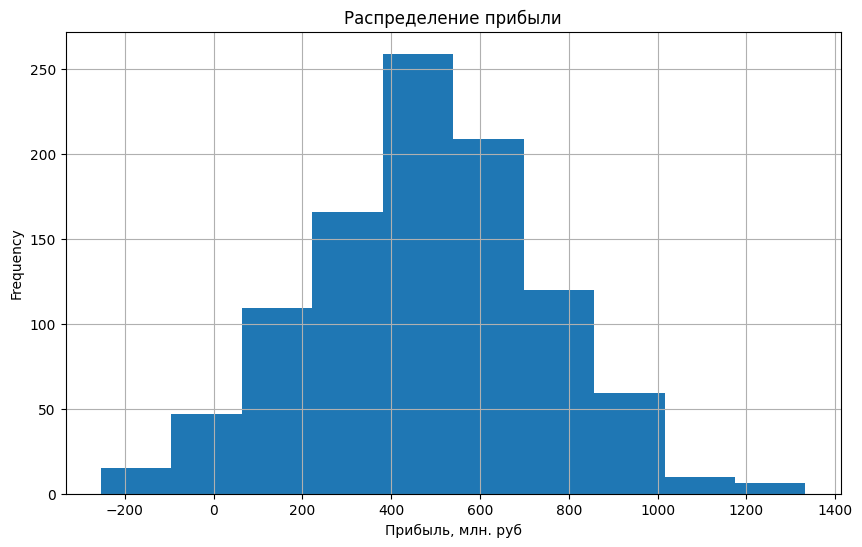

Средняя прибыль составляет 477.42 млн. руб
95%-ый доверительный интервал: от -58.0 до 974.82 млн.руб
Процент вероятности убытка в данном регионе составит 4.1%


In [45]:
bootstap_1000(predict_geo_0, target_geo_0_valid)

 ### Распределение прибыли второго региона

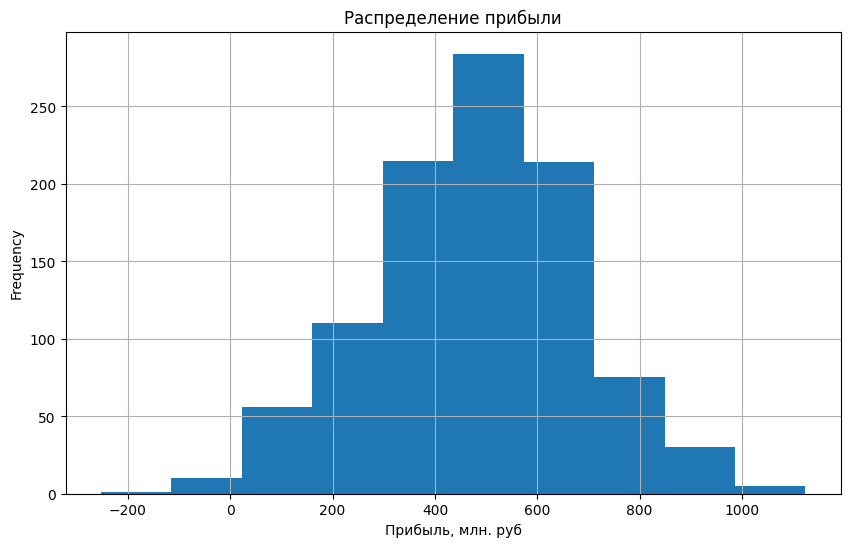

Средняя прибыль составляет 479.19 млн. руб
95%-ый доверительный интервал: от 58.72 до 874.43 млн.руб
Процент вероятности убытка в данном регионе составит 0.9%


In [46]:
bootstap_1000(predict_geo_1, target_geo_1_valid)

 ### Распределение прибыли третьего региона

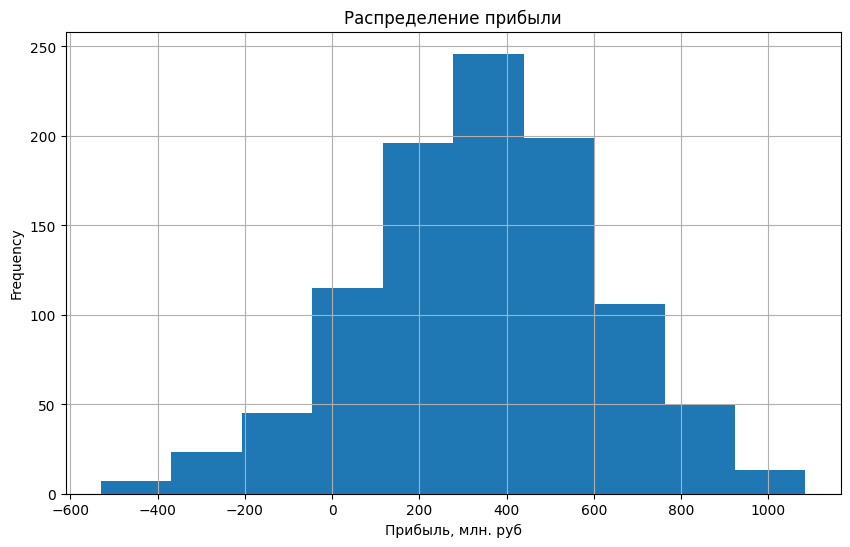

Средняя прибыль составляет 343.45 млн. руб
95%-ый доверительный интервал: от -231.38 до 860.84 млн.руб
Процент вероятности убытка в данном регионе составит 9.9%


In [47]:
bootstap_1000(predict_geo_2, target_geo_2_valid)

### Выводы

У нас есть допустимый максимум вероятности убытков - это *2.5%*. Как видим по результатам первый и третий регион, к сожалению, не умещаются в это значение (риск убытков *4.1%* и *9.9%* соответственно). Поэтому предпочтительней всего для начала разработки скважин является ***второй регион*** (риск убытков составил всего *0.9%*) со средней прибылью в *479.19 млн. руб*.

## Общий вывод

В данном проекте мы провели исследование по изучению скважин в трёх различных регионах и выполнили это в несколько этапов:
1. Загрузили и подготовили данные со всех трёх регионов.
2. Обучили и проверили модель линейной регрессии для каждого региона:
  * разбили данные на обучающую и валидационную выборки в соотношении 75:25;
  * обучили модель и сделали предсказания на валидационной выборке;
  * посчитали средний запас предсказанного сырья и RMSE модели (наилучший результат получили при предсказании во второй регионе - RMSE составила всего *0.88*).
3. Подготовили все данные к расчёту прибыли:
  * все ключевые значения для расчётов сохранили в отдельных переменных;
  * рассчитайте достаточный объём сырья для безубыточной разработки новой скважины (*111.11* тыс. баррелей) и сравнили полученный объём сырья со средним запасом в каждом регионе (во всех регионах средний объём запасов сырья не дотягивает до минимального объёма).
4. Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели, в которой:
  * выберали скважины с максимальными значениями предсказаний;
  * просуммировали целевое значение объёма сырья, соответствующее этим предсказаниям;
  * рассчитали прибыль для полученного объёма сырья.
5. Посчитали риски и прибыль для каждого региона:
  * применили технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли;
  * найшли среднюю прибыль, 95%-й доверительный интервал и риск убытков.

По итогу мы получили следующие результаты: первый и третий регион, к сожалению, не умещаются в максимальнодопустимое значение вероятностей убытков (*2.5%*), так как их риск убытков составил *4.1%* и *9.9%* соответственно. Поэтому предпочтительней всего для начала разработки скважин является ***второй регион*** (риск убытков составил всего *0.9%*) со средней прибылью в *479.19 млн. руб*.